<a href="https://colab.research.google.com/github/GubioGL/Optics/blob/main/Gaus_com_fase_circular_com_valor_aleat%C3%B3rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Pacotes 
!pip install --upgrade LightPipes
from LightPipes import *
from matplotlib import image
from scipy.fft import fft2, ifft2 ,fftshift
from scipy import special
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy

     |████████████████████████████████| 50 kB 2.7 MB/s 


In [ ]:
#Pedidno permissão para ter acesso ao drive
import PIL
from PIL import Image
from google.colab import drive
import random
drive.mount('/content/drive', True)
SLM  = Image.open('/content/drive/MyDrive/Colab Notebooks/Gubio/DD.png')

imgGray = SLM.convert('L')
imgGray.save('imgGray2.jpg')
imgGra  = plt.imread('imgGray2.jpg')
ri = imgGra/imgGra.max()

Mounted at /content/drive


  Distribuição de intensidade Gaussiana , com cintura do feixe w_0.
Foi criado 100 feixes com valores aleatoriode cintura diferentes dentor de um range de valores.

  Sobre a Fase, como proposto pela Nara, criei um perfil de fase que tem cara da fase de LG(0,1), quadrado com um circulo no meio. Com apenas dois valores um para o cículo e outro para o resto. 

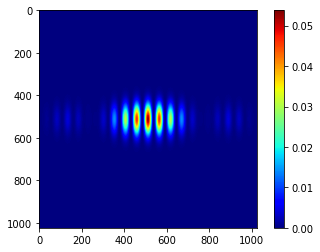

In [ ]:
########################################################################
P = 0 
L = 0
n = 2**10 + 1
lamb = 512*nm        
k = 2*np.pi/lamb        
w_0 = 1.6*mm          
z_R = np.pi*w_0**2/lamb      
########################################################################
dx = 17*um  
x = np.arange(-n/2+1, n/2,1)*dx
y = np.arange(-n/2+1, n/2,1)*dx
xx,yy = np.meshgrid(x,y)
########################################################################
dzPar = np.arange(1e-20,100,1)*cm  
z = dzPar[0]       
###############################################################################
N_inc = 100
i=0
SI = [0]

while (i<N_inc):
  i+=1
###############################################################################
#### Perfil de Intensidade   
  r    = np.sqrt(xx**2+yy**2)                                                 
  C    = np.sqrt(2*np.math.factorial(P)/(np.pi*np.math.factorial(P+abs(L))))  
  w    = w_0*np.sqrt(1+(z/z_R)**2)
  R    = z*(1+(z_R/z)**2)
  phi  = (1+2*P+abs(L))*np.arctan(z/z_R)  
  PL   = scipy.special.assoc_laguerre(2*r**2/w**2,P,abs(L))
  Fase = np.exp( -r**2/w**2 - 1j*k*r**2/(2*R) + 1j*phi - 1j*L*np.arctan2(yy,xx) )*np.exp(-1j*k*z)
  GAUSSIAN = C*w_0/w*(r*np.sqrt(2)/w)**abs(L)*PL*Fase
##############################################################################

  F = Begin(2*abs(x[1]),lamb,n-1);    # Criando o Campo no Lpipe
  Fn = F.copy(F)
  Fn.field = GAUSSIAN            # Modulando a Campo criado

###############################################################################
### Criando a fase 
 
  R = 4*mm                        # Raio do círculo 
  A = CircAperture(R, 0, 0, F)    # Criando o círculo,2° posição x;3° posição y
  ftrm = random.random()*2*np.pi  # Fator multiplicativo aleatório
  AA = A.field*ftrm               # Coletando a matriz, parte do círculo
  ftm2 = random.random()*2*np.pi  # 2° Fator multiplicativo
  BB = F.field                    # Matriz do campo Ini. com números 1
  CC = (BB-A.field)*ftm2          # Parte de fora do círculo
  D = CC+AA                       # Juntando as duas partes
  ##### Alterando a antiga fase   ############  
  EE = SubPhase(D,Fn) 
  EEint = EE.field*ri             # Interferência

  Fint = F.copy(F)
  Fint.field = EEint

  propagação = Forvard(90*cm,Fint)# Propagador 
  imagem = Intensity(0,propagação)# Intensidade
  
  #plt.imshow(imagem,cmap='jet')
  #plt.colorbar()
  #plt.show()

  #fase = Phase(EE)
  #plt.imshow(fase,cmap='jet')
  #plt.colorbar()
  #plt.show()
  
  SI = SI + imagem

imagem = SI/N_inc
   
plt.imshow(imagem,cmap='jet')
plt.colorbar()
plt.show()
##############################################################################

In [ ]:
# Ajustado para analisar na Direita e esquerda
### Função da Suavização #########################
def SUAVE(media, linha):
  novalista = []
  for i in range(media ,1024,1):
    b = imagem[linha,i-media:i]
    AA = sum(b)/media
    novalista.append(AA)
  return np.array(novalista)

def MM(suavizar,linha):
  maxi2 = SUAVE(suavizar,linha).max()
  posiçao2 = 0
  for i in SUAVE(suavizar,linha):
    if i == maxi2:
      break 
    posiçao2 +=1 

#### Encontrar o valor mínimo local a Direita parti do maximo global
  mini = 0
  Vimax = SUAVE(suavizar,linha)[posiçao2:1024]
  for i in range(len(Vimax)):
    if i == len(Vimax)-1:
      break
    if Vimax[i] > Vimax[i+1]:
      mini = Vimax[i+1]
    elif Vimax[i] < Vimax[i+1]:
      mini = Vimax[i]
      break   
  # Vamos encontrar o posição no qual temos mínimo
  PMin = 0 
  for i in Vimax:
    if i == mini:
      break 
    PMin += 1  
  posiçaomin = posiçao2 + PMin -1
#######################################################################
#### Encontrar o valor mínimo local a ESQUERDA a parti do maximo lobal
  miniE = 0
  xamiV = SUAVE(suavizar,linha)[0:posiçao2]
#########################################################
  for i in range(len(xamiV)):
    i += 1
    if i == len(xamiV)-1:
      break
    if xamiV[-i] > xamiV[-i-1]:
      miniE = xamiV[-i-1]
    elif xamiV[-i] < xamiV[-i-1]:
      miniE = xamiV[-i]
      break   
  # Vamos encontrar o posição no qual temos mínimo
  PMinE = 0 
  for i in range(len(xamiV)):
    i+=1
    if xamiV[-i] == miniE: 
      break 
    PMinE += 1  
  posiçaominE = posiçao2 - PMinE

  if miniE > mini:
    posiçaomin = posiçaominE
    mini       = miniE
  # [0] = Valor max,[1] = Posição max ,[2] = Valor Min,[3] = Posição Min
  return maxi2, posiçao2, mini, posiçaomin  #,miniE, posiçaominE 

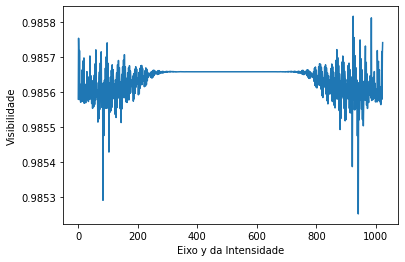

In [ ]:
# A VISIBILIDADE TODA
VisibilidadeN = []
Qsuavi =5
for j in range(0,1024):
  V = ( MM(Qsuavi,j)[0]  - MM(Qsuavi,j)[2] )/( MM(Qsuavi,j)[0]  + MM(Qsuavi,j)[2])
  VisibilidadeN.append(V) 
  
plt.plot(VisibilidadeN) 
plt.xlabel('Eixo y da Intensidade')
plt.ylabel("Visibilidade")
plt.show()


(0.05378707117413288, 511, 2.6970013835374914e-05, 537)


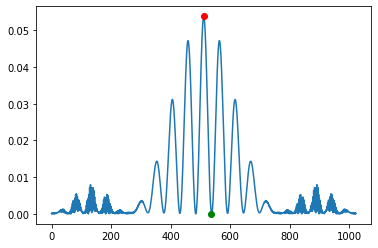

Visibilidade = 0.9970754480411647


In [ ]:
qe =1
qw = 512
print(MM(qe,qw))

# DISTRIBUIÇÃO DE INTENSIDADE

plt.plot(imagem[qw])
plt.plot(MM(qe,qw)[1] , MM(qe,qw)[0] , 'o', color ='red'  )
plt.plot(MM(qe,qw)[3] , MM(qe,qw)[2] , 'o', color ='green'  )
plt.show()

# VISIBILIDADE

V = ( MM(2,qw)[0]  - MM(2,qw)[2] )/( MM(2,qw)[0]  + MM(2,qw)[2])
print("Visibilidade =",V)